# Punto 1 - Italian
## Automatic identification of “trending/viral” topics around COVID in time in the World using deep learning architectures. Type: Different approaches.

In [1]:
import pickle as pk
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import umap.umap_ as umap


## Files used
The datasets and the embedings generated with a pretrained Sentence Bert model

In [6]:
#prefix = './drive/MyDrive/'
prefix = ''
italian_path = prefix + 'datasets/italian/italian_out_hash_bien.json'

#prefix = './drive/MyDrive/'
prefix = ''
italian_embeddings_path = prefix + 'models_hpc/embeddings_ita_v2.pickle'

#prefix = './drive/MyDrive/'
prefix = ''
umap_italian_embeddings_path = prefix + 'models_hpc/umap_ita_v2.pickle'

In [3]:
file = open(italian_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
text_raw_df = pd.json_normalize(data)

print(text_raw_df.shape)
text_raw_df.head(10)

(814485, 4)


,id,publication_date,source,text
0,1324811856859533313,1.604695e+09,twitter,Il prof. #Galli è molto preoccupato da quanto ...
1,1288746494368124928,1.596096e+09,twitter,Il COVID-19 coincide con un momento cruciale n...
2,1326191597785059329,1.605024e+09,twitter,Muoviamoci #vaccinoCovid #coronavirus #COVID19...
3,1275134048722132993,1.592851e+09,twitter,@mosllerdd @Cartabellotta Si sarebbero potute ...
4,1243118079091118080,1.585217e+09,twitter,@morzo6 @CNN Purtroppo sì. State a casa. Disin...
5,1267645840455278594,1.591065e+09,twitter,"@orticArya * ""il coronavirus non c'è più, ma c..."
6,1233340720460726272,1.582886e+09,twitter,"Coronavirus, l’ultima trovata: mascherine grif..."
7,1279712208612667393,1.593942e+09,twitter,"""Penne in quarantena"". Tredici #racconti di al..."
8,1271709738301095936,1.592034e+09,twitter,"Cina, torna l’incubo Coronavirus: alcuni quart..."
9,1296853994686513152,1.598029e+09,twitter,Questo è il punto


In [4]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw_df.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Il prof. #Galli è molto preoccupato da quanto sta accadendo a #Milano '

In [7]:
#with open(italian_embeddings_path, "rb") as output_file:
#    embeddings = pk.load(output_file)

with open(umap_italian_embeddings_path, "rb") as output_file:
    umap_embeddings = pk.load(output_file)

### HDBSCAN para el clustering

In [8]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=70,
                          metric='euclidean',
                          cluster_selection_method='eom',
                          min_samples=300).fit(umap_embeddings)

### Visualisación de los clusters

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [9]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('italian')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [11]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df);
topic_sizes.head(10)

,Topic,Size
0,-1,518352
126,125,30339
129,128,20123
65,64,17957
109,108,17945
56,55,15967
119,118,15004
22,21,12378
122,121,11895
76,75,8450


In [12]:
len(topic_sizes)

152

In [14]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')



Topic #125:

['coronavirus', 'virus', 'covid19', 'coronavirusitalia', 'solo', 'cosa', 'quando', 'fa', 'covid_19', 'fatto']

Topic #128:

['sempre', 'bene', 'cazzo', 'cosa', 'così', 'quando', 'eh', 'solo', 'proprio', 'mai']

Topic #64:

['coronavirus', 'covid', '19', 'positivi', 'casi', 'emergenza', 'nuovi', 'italia', 'abruzzo', 'covid19']

Topic #108:

['covid19', '19', 'covid', 'emergenza', 'crisi', 'dopo', 'lavoro', 'tempi', 'cosa', 'solo']

Topic #55:

['calcio', 'positivo', '19', 'covid', 'serie', 'sport', 'positivi', 'coronavirus', 'inter', 'seriea']

Topic #118:

['vaccino', 'vaccini', 'covid19', 'covid', 'anti', '19', 'astrazeneca', 'pfizer', 'vaccinazione', 'vaccinazioni']

Topic #21:

['cina', 'cinese', 'cinesi', 'coronavirus', 'pechino', 'wuhan', 'china', 'italia', 'virus', 'oms']

Topic #121:

['giuseppeconteit', 'matteosalvinimi', 'robersperanza', 'robertoburioni', 'cartabellotta', 'corriere', 'giorgiameloni', 'cosa', 'borghi_claudio', 'solo']

Topic #75:

['medici', 'sanit

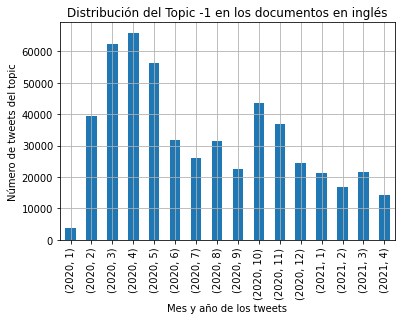

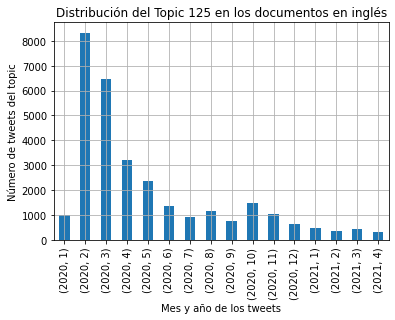

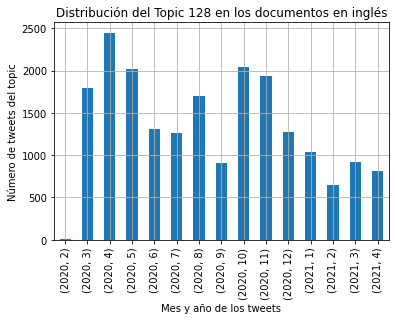

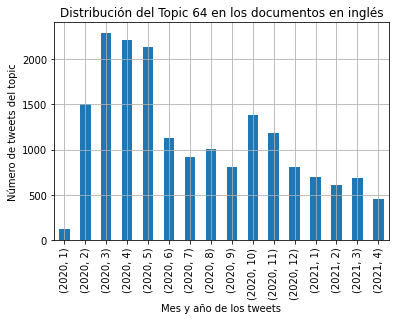

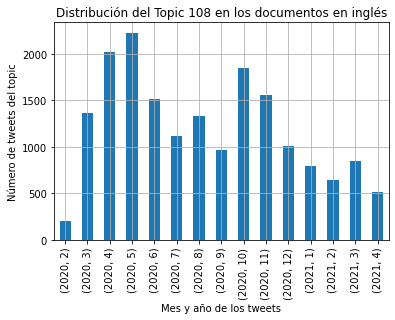

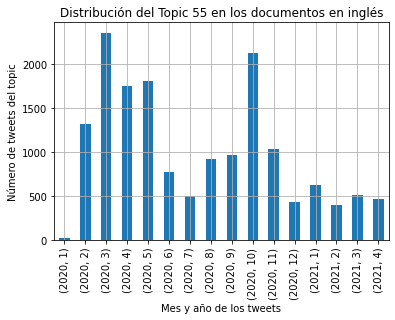

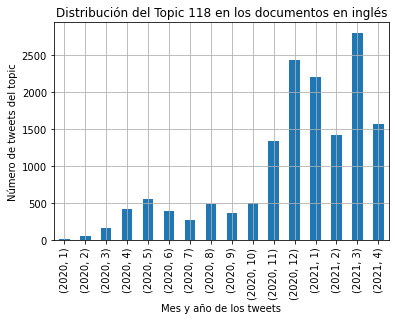

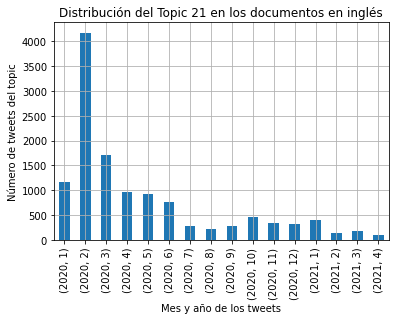

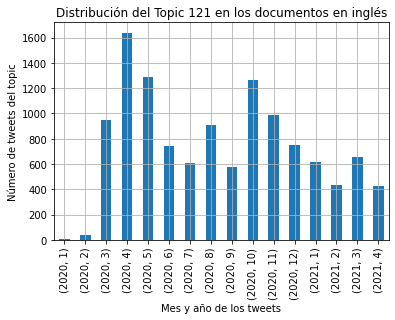

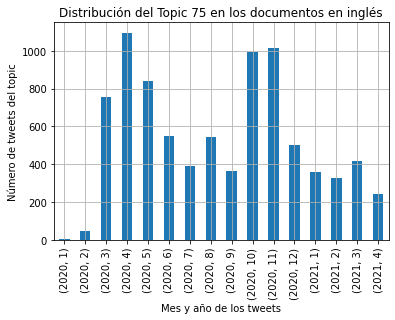

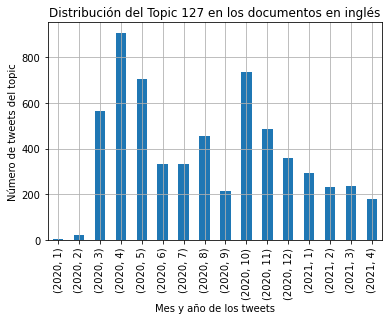

In [15]:
import matplotlib.pyplot as plt
from datetime import datetime


text_raw_df['dates'] =  text_raw_df['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
text_raw_df['Topic'] = cluster.labels_

i = 0
for num_topic in topic_sizes['Topic']:
    ax = text_raw_df.groupby([text_raw_df['Topic'], text_raw_df['dates'].dt.year, text_raw_df['dates'].dt.month]).count()['id'][num_topic].plot(kind="bar") #Imprime el topic cero
    ax.grid(b=True, axis='both')
    #print(type(ax))
    ax.set_title('Distribución del Topic ' + str(num_topic) + ' en los documentos en inglés')
    ax.set_xlabel('Mes y año de los tweets')
    ax.set_ylabel('Número de tweets del topic')
    plt.show()
    i = i+1
    if (i>10):
        break




# Italian with different params on HDBScan

In [10]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=70,
                          metric='euclidean',
                          cluster_selection_method='eom',
                          min_samples=400).fit(umap_embeddings)

### Visualisación de los clusters

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [11]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [12]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('italian')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [13]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df);
topic_sizes.head(10)

,Topic,Size
4,3,808009
0,-1,4149
2,1,1452
1,0,697
3,2,178


In [14]:
len(topic_sizes)

5

In [17]:
print(len(topic_sizes['Topic']))
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


5
Topic #3:

['coronavirus', 'covid19', 'covid', 'casi', '19', 'italia', 'nuovi', 'positivi', 'contagi', 'oggi']

Topic #1:

['sale', 'totale', 'paese', 'decessi', 'morti', 'mondo', 'nuovi', 'ncov', 'polmonite', '2019']

Topic #0:

['pezzo', 'interessa', 'piacere', 'grazie', 'pomeriggio', 'buon', 'follow', 'prego', 'ricambiato', 'pezzi']

Topic #2:

['radioradiotv', 'dicono', 'savona', 'spezia', 'imperia', 'genova', 'coronavirus', 'covid19', '091', '62']



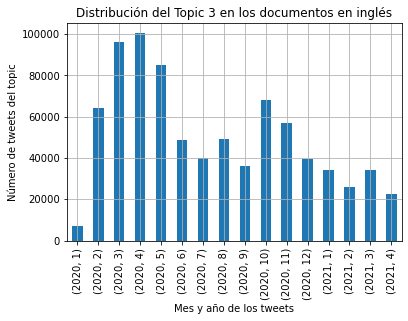

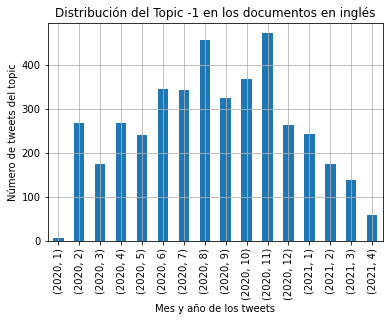

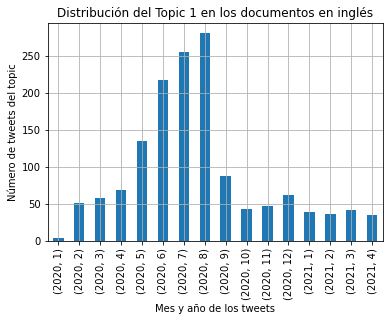

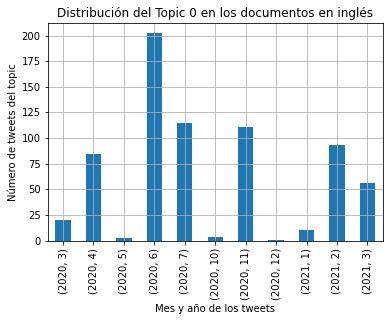

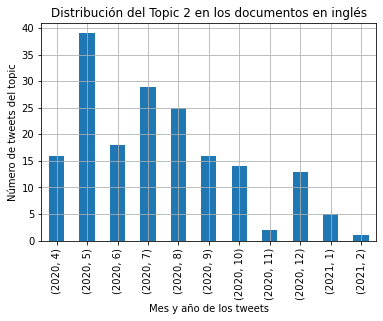

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime


text_raw_df['dates'] =  text_raw_df['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
text_raw_df['Topic'] = cluster.labels_
text_raw_df


for num_topic in topic_sizes['Topic']:
    ax = text_raw_df.groupby([text_raw_df['Topic'], text_raw_df['dates'].dt.year, text_raw_df['dates'].dt.month]).count()['id'][num_topic].plot(kind="bar") #Imprime el topic cero
    ax.grid(b=True, axis='both')
    #print(type(ax))
    ax.set_title('Distribución del Topic ' + str(num_topic) + ' en los documentos en inglés')
    ax.set_xlabel('Mes y año de los tweets')
    ax.set_ylabel('Número de tweets del topic')
    plt.show()

